In [1]:
# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2

import numpy as np

from scipy.interpolate import UnivariateSpline

In [158]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq."""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)]).T

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return np.dot(p,mua) + np.dot(q,mud)


def return_rgal(l,b):
    """ eq."""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)]).T

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return np.dot(p,mul) + np.dot(q,mub)


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.dot(p.T,mugal)
    mub = np.dot(q.T,mugal)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)

def rotate_positions(a,d):
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    return ell,b


a = 45.*np.pi/180.
d = 60.*np.pi/180.

mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

cov_to = rotate_errors(a,d,1,2.,0.)
print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)
[[ 1.67274602 -1.25125971]
 [-1.25125971  3.32725398]]


In [16]:
KGiants = np.genfromtxt('processed/matchingKgiants.txt',\
                    dtype={'names': ('Name','ra','dec','dist'),\
                          'formats': ('S20','f8','f8','f8')},\
                    skip_header=1,delimiter=',')


BHBs = np.genfromtxt('data/matchingbhb.txt',\
                    dtype={'names': ('Name','ra','dec','dist'),\
                          'formats': ('S20','f8','f8','f8')},\
                    skip_header=1,delimiter=' ')


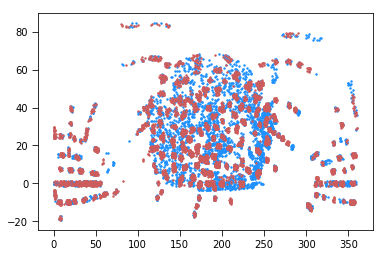

In [6]:
plt.scatter(BHBs['ra'],BHBs['dec'],color='dodgerblue',s=2)
plt.scatter(KGiants['ra'],KGiants['dec'],color='indianred',s=2)

In [8]:
# read in the QSO positions

f = open('/Users/mpetersen/Downloads/allwise_AGN.txt')


ras  = []
decs = []

for line in f:
    if line[0] == 'J':
        ras.append(float(line[20:32]))
        decs.append(float(line[33:44]))
    

f.close()


In [13]:
RA = np.array(ras)
DEC = np.array(decs)
print(np.nanmin(RA),np.nanmax(RA))

5.27e-05 359.9998334


In [14]:
# look for the closest points...
def spatial_distance(ra1,ra2,dec1,dec2):
    """compute a simple spherical onsky distance"""
    
    deltara  = 15.*np.cos(dec1)*np.abs(ra1-ra2)
    deltadec = np.abs(dec1-dec2)
    
    return np.sqrt(deltara*deltara + deltadec*deltadec)
    


In [79]:

f = open('/Users/mpetersen/Downloads/comp_quasars_30.txt','w')

print('indx,internal,sep,RA,Dec,cRA,cDec',file=f)

indx = -1

ww = np.where(KGiants['dist']>50)[0]
for i in ww:
    #print(i)
    closest = spatial_distance((np.pi/180.)*KGiants['ra'][i],(np.pi/180.)*RA,\
                               (np.pi/180.)*KGiants['dec'][i],(np.pi/180.)*DEC)
    
    csort = closest.argsort()
    cc = closest[csort]
    
    for ii,dval in enumerate(cc[0:30]):
        indx += 1
        print(str(indx)+',K{0},{1:5.4f},{2},{3},{4},{5}'.format(i,dval,RA[csort[ii]],DEC[csort[ii]],KGiants['ra'][i],KGiants['dec'][i]),file=f)
    

ww = np.where(BHBs['dist']>50)[0]
for i in ww:
    #print(i)
    closest = spatial_distance((np.pi/180.)*BHBs['ra'][i],(np.pi/180.)*RA,\
                               (np.pi/180.)*BHBs['dec'][i],(np.pi/180.)*DEC)
    
    csort = closest.argsort()
    cc = closest[csort]
    
    for ii,dval in enumerate(cc[0:30]):
        indx += 1
        print(str(indx)+',B{0},{1:5.4f},{2},{3},{4},{5}'.format(i,dval,RA[csort[ii]],DEC[csort[ii]],BHBs['ra'][i],BHBs['dec'][i]),file=f)
    
    

f.close()

In [80]:
# the 10 closest at each location
QSOs = np.genfromtxt('/Users/mpetersen/Downloads/comp_quasars.txt',\
                    dtype={'names': ('indx','internal','sep','RA','Dec','cRA','cDec'),\
                          'formats': ('i4','S20','f8','f8','f8','f8','f8')},\
                    skip_header=1,delimiter=',')


# the 30 closest at each location
QSOs = np.genfromtxt('/Users/mpetersen/Downloads/comp_quasars_30.txt',\
                    dtype={'names': ('indx','internal','sep','RA','Dec','cRA','cDec'),\
                          'formats': ('i4','S20','f8','f8','f8','f8','f8')},\
                    skip_header=1,delimiter=',')

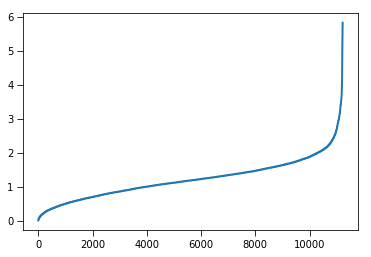

In [81]:
plt.plot(60.*QSOs['sep'][QSOs['sep'].argsort()])

In [82]:
# AND  EQ 31
# AND  GE 8




infile = '/Users/mpetersen/Downloads/1595853880600O-result.csv'
infile = '/Users/mpetersen/Downloads/qsomatch30-result.csv'


f = open(infile)
firstcol = f.readline()

kvals = firstcol.split(',')
formats = ['f8' for i in range(0,len(kvals))]

G = np.genfromtxt(infile,\
                        dtype={'names': kvals,\
                             'formats': formats},\
                 skip_header=1,delimiter=',')

print(kvals)

print(G['indx'].astype('int').size)
print(np.unique(G['indx'].astype('int')).size)

g = np.where( (G['astrometric_params_solved']==31) &\
              (G['astrometric_matched_observations']>=8) &\
              (G['dist']<0.0001) &\
              ((G['parallax']+0.029)/G['parallax_error'] < 5) &\
              (((G['pmra']/G['pmra_error'])**2. + (G['pmdec']/G['pmdec_error'])**2.) < 25))


print(g[0].size)

['indx', 'source_id', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax', 'parallax_error', 'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 'phot_g_mean_mag', 'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'bp_rp', 'radial_velocity', 'radial_velocity_error', 'phot_variable_flag', 'teff_val', 'a_g_val', 'pmra_pmdec_corr', 'astrometric_params_solved', 'astrometric_matched_observations', 'dist\n']
4266
4258
3214


In [178]:
names = QSOs['internal'][G['indx'][g].astype('int')]
#print(np.unique(names))

unis = np.unique(names)
arrx = np.zeros(unis.size)
arry = np.zeros(unis.size)
arrx2 = np.zeros(unis.size)
arry2 = np.zeros(unis.size)
arrx3 = np.zeros(unis.size)
arry3 = np.zeros(unis.size)

ui = 0
for u in unis:
    ww = np.where(QSOs['internal'][G['indx'][g].astype('int')]==u)
    #print(np.nanmeanww[0])
    #plt.scatter([np.nanmean(G['pmra'][g][ww[0]])],[np.nanmean(G['pmdec'][g][ww[0]])],color='black',s=1.)
    
    # compute a transformation
    arrx[ui],arry[ui] = rotate_positions((np.pi/180.)*np.nanmean(G['ra'][g][ww[0]]),(np.pi/180.)*np.nanmean(G['dec'][g][ww[0]]))
    arrx2[ui],arry2[ui] = rotate_velocities((np.pi/180.)*np.nanmean(G['ra'][g][ww[0]]),(np.pi/180.)*np.nanmean(G['dec'][g][ww[0]]),\
                                           np.nanmean(G['pmra'][g][ww[0]]),np.nanmean(G['pmdec'][g][ww[0]]))
    cov_to = rotate_errors(np.nanmean((np.pi/180.)*G['ra'][g][ww[0]]),np.nanmean((np.pi/180.)*G['dec'][g][ww[0]]),\
                                           np.nanmean(G['pmra_error'][g][ww[0]]),np.nanmean(G['pmdec_error'][g][ww[0]]),\
                                           np.nanmean(G['pmra_pmdec_corr'][g][ww[0]]))
    arrx3[ui],arry3[ui] = np.sqrt(cov_to[0][0]),np.sqrt(cov_to[1][1])
    #arrx[ui] = np.nanmean(G['pmra'][g][ww[0]])
    #arry[ui] = np.nanmean(G['pmdec'][g][ww[0]])
    #arrx2[ui] = np.nanmean(G['ra'][g][ww[0]])
    #arry2[ui] = np.nanmean(G['dec'][g][ww[0]])
    ui+=1

#print(np.unique(names).size)

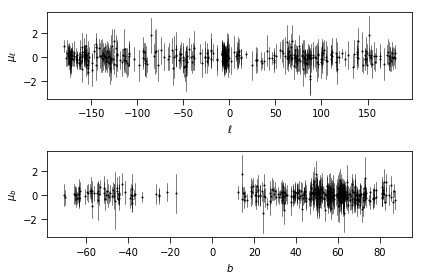

In [180]:

fig = plt.figure(figsize=(6,4))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)


ax1.scatter((180./np.pi)*arrx,arrx2,color='black',s=1.)
ax2.scatter((180./np.pi)*arry,arry2,color='black',s=1.)

for indx in range(0,arrx2.size):
    ax1.plot([(180./np.pi)*arrx[indx],(180./np.pi)*arrx[indx]],\
             [arrx2[indx]-arrx3[indx],arrx2[indx]+arrx3[indx]],color='black',lw=0.5)
    ax2.plot([(180./np.pi)*arry[indx],(180./np.pi)*arry[indx]],\
             [arry2[indx]-arry3[indx],arry2[indx]+arry3[indx]],color='black',lw=0.5)


    
    
ax1.set_xlabel('$\ell$',size=10)
ax2.set_xlabel('$b$',size=10)

ax1.set_ylabel('$\mu_\ell$',size=10)
ax2.set_ylabel('$\mu_b$',size=10)

fig.tight_layout()
plt.savefig('figures/quasar_position_bias.png',dpi=300)


[-1.722 -1.387 -1.685 ... -1.523 -1.793 -1.308]


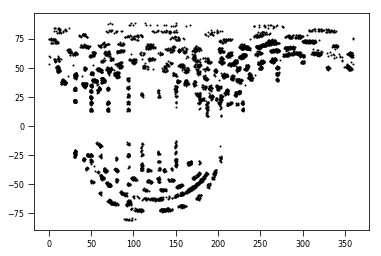

In [231]:

In = np.genfromtxt('processed/BHBs_cartesian_heliocentric.txt',skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l2    = In[:,6]
b2    = In[:,7]
d2    = In[:,8]
vr   = In[:,9]
dml2  = In[:,10]
dmb2  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml2 = In[:,14]
edmb2 = In[:,15]

sgrweak = In[:,16]
sgrstrong = In[:,17]

feh = In[:,18]
corr = In[:,22]
sgrb2 = In[:,20]

print(feh)

Lx,Ly,Lz = return_angular_momentum(In)
d2 = In[:,8]
ldiff2 = clean_sgr(Lx,Ly,Lz,sgrvals)



plt.scatter(l,b,color='black',s=1.)
#plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

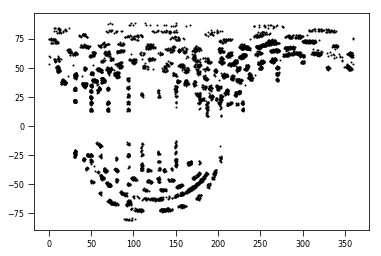

In [227]:
#In = np.genfromtxt('/Users/mpetersen/Dropbox/mike/data/KGiants_cartesian_galactocentric_II.txt',skip_header=1)

In = np.genfromtxt('processed/KGiants_cartesian_heliocentric_sgr.txt',skip_header=1)



x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

#tl,tb,td,tvr,tdml,tdmb = jorge_galactic(x,y,z,vx,vy,vz)


l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

sgrweak = In[:,16]
sgrstrong = In[:,17]
feh = In[:,18]

sgrl = In[:,19]
sgrb = In[:,20]

corr = In[:,22]


plt.scatter(l,b,color='black',s=1.)
plt.scatter(l[sgrstrong==1],b[sgrstrong==1],color='red',s=20.)

In [229]:

def return_angular_momentum(In):
    
    x    = In[:,0]
    y    = In[:,1]
    z    = In[:,2]
    vx   = In[:,3]
    vy   = In[:,4]
    vz   = In[:,5]
    
    Lx = (y*vz - z*vy)
    Ly = (z*vx - x*vz)
    Lz = (x*vy - y*vx)

    return Lx,Ly,Lz



def clean_sgr(Lx,Ly,Lz,sgrcen):
    lxdiff = Lx - sgrcen[0]
    lydiff = Ly - sgrcen[1]
    lzdiff = Lz - sgrcen[2]
    ldiff = np.sqrt(lxdiff*lxdiff + lydiff*lydiff + lzdiff*lzdiff)
    return ldiff

sgrvals = [605, -4515, -1267]



Lx,Ly,Lz = return_angular_momentum(In)
d = In[:,8]
ldiff = clean_sgr(Lx,Ly,Lz,sgrvals)



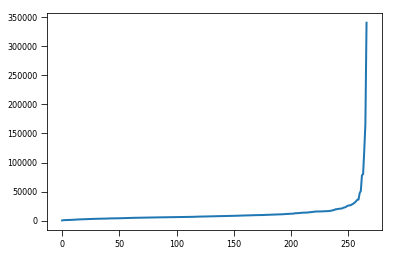

In [230]:
plt.plot(ldiff[d>50][ldiff[d>50].argsort()])

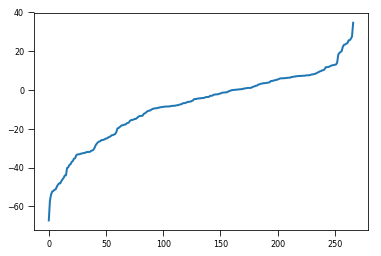

In [218]:
gg = np.where(d>50)

plt.plot(sgrb[gg][sgrb[gg].argsort()])

In [225]:
gdist = np.where((d>50) & (np.abs(sgrb)>5) & (np.abs(sgrl)>60))[0]

print(gdist.size)

191


238


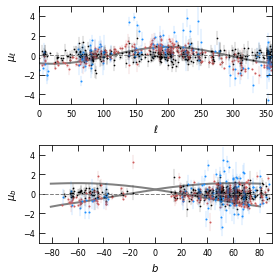

In [240]:
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

fig = plt.figure(figsize=(4,4))

ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

arrx[arrx<0] += 2.*np.pi


ax1.scatter((180./np.pi)*arrx,arrx2,color='black',s=0.5)
ax2.scatter((180./np.pi)*arry,arry2,color='black',s=0.5)

for indx in range(0,arrx2.size):
    ax1.plot([(180./np.pi)*arrx[indx],(180./np.pi)*arrx[indx]],\
             [arrx2[indx]-0.5*arrx3[indx],arrx2[indx]+0.5*arrx3[indx]],color='black',lw=0.2)
    ax2.plot([(180./np.pi)*arry[indx],(180./np.pi)*arry[indx]],\
             [arry2[indx]-0.5*arry3[indx],arry2[indx]+0.5*arry3[indx]],color='black',lw=0.2)


gdist = np.where((d>50) & (ldiff>3000))[0]
print(gdist.size)

for i in gdist:
    ax1.scatter(l[i],dml[i],color='indianred',s=1.)
    ax1.plot([l[i],l[i]],[dml[i]-edml[i],dml[i]+edml[i]],color='indianred',lw=0.2)
    ax2.scatter(b[i],dmb[i],color='indianred',s=1.)
    ax2.plot([b[i],b[i]],[dmb[i]-edmb[i],dmb[i]+edmb[i]],color='indianred',lw=0.2)


gdist = np.where((d2>50) & (ldiff2>3000))[0]

for i in gdist:
    ax1.scatter(l2[i],dml2[i],color='dodgerblue',s=1.)
    ax1.plot([l2[i],l2[i]],[dml2[i]-edml2[i],dml2[i]+edml2[i]],color='dodgerblue',lw=0.2)
    ax2.scatter(b2[i],dmb2[i],color='dodgerblue',s=1.)
    ax2.plot([b2[i],b2[i]],[dmb2[i]-edmb2[i],dmb2[i]+edmb2[i]],color='dodgerblue',lw=0.2)



ax1.plot([0.,360.],[0.,0.],color='grey',linestyle='dashed',lw=1.)
ax2.plot([-90.,90.],[0.,0.],color='grey',linestyle='dashed',lw=1.)

lmodel = np.genfromtxt('processed/model_l_values.txt')
ax1.plot(360.-(180./np.pi)*lmodel[:,0],-1.*lmodel[:,1],linestyle='solid',lw=2.,color='grey',zorder=-10)

bmodel = np.genfromtxt('processed/model_b_values.txt')
ax2.plot((180./np.pi)*bmodel[:,0],1.3*bmodel[:,2]-0.2,linestyle='solid',lw=2.,color='grey',zorder=-10)
ax2.plot((180./np.pi)*bmodel[:,0],1.3*bmodel[:,3]-0.2,linestyle='solid',lw=2.,color='grey',zorder=-10)



    
ax1.set_xlabel('$\ell$',size=10)
ax2.set_xlabel('$b$',size=10)

ax1.set_ylabel('$\mu_\ell$',size=10)
ax2.set_ylabel('$\mu_b$',size=10)

ax1.axis([0.,360.,-5.,5.])
ax2.axis([-90,90.,-5.,5.])

for ax in [ax1,ax2]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)


fig.tight_layout()
plt.savefig('figures/quasar_position_bias_wkgiants.png',dpi=500)



238


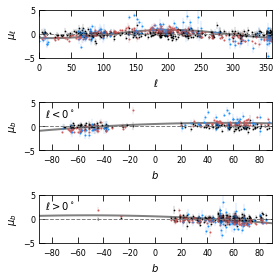

In [251]:
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8

fig = plt.figure(figsize=(4,4))

ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)


arrx[arrx<0] += 2.*np.pi


ax1.scatter((180./np.pi)*arrx,arrx2,color='black',s=0.5)
ax2.scatter((180./np.pi)*arry[arrx<np.pi],arry2[arrx<np.pi],color='black',s=0.5)
ax3.scatter((180./np.pi)*arry[arrx>np.pi],arry2[arrx>np.pi],color='black',s=0.5)



for indx in range(0,arrx2.size):
    ax1.plot([(180./np.pi)*arrx[indx],(180./np.pi)*arrx[indx]],\
             [arrx2[indx]-0.5*arrx3[indx],arrx2[indx]+0.5*arrx3[indx]],color='black',lw=0.2)
    if arrx[indx] < np.pi:
        ax2.plot([(180./np.pi)*arry[indx],(180./np.pi)*arry[indx]],\
             [arry2[indx]-0.5*arry3[indx],arry2[indx]+0.5*arry3[indx]],color='black',lw=0.2)
    if arrx[indx] > np.pi:
        ax3.plot([(180./np.pi)*arry[indx],(180./np.pi)*arry[indx]],\
             [arry2[indx]-0.5*arry3[indx],arry2[indx]+0.5*arry3[indx]],color='black',lw=0.2)




gdist = np.where((d>50) & (ldiff>3000))[0]
print(gdist.size)

for i in gdist:
    ax1.scatter(l[i],dml[i],color='indianred',s=1.)
    ax1.plot([l[i],l[i]],[dml[i]-edml[i],dml[i]+edml[i]],color='indianred',lw=0.2)

    
gdist = np.where((d>50) & (ldiff>3000) & (l<180.))[0]
for i in gdist:
    ax2.scatter(b[i],dmb[i],color='indianred',s=1.)
    ax2.plot([b[i],b[i]],[dmb[i]-edmb[i],dmb[i]+edmb[i]],color='indianred',lw=0.2)

gdist = np.where((d>50) & (ldiff>3000) & (l>180.))[0]
for i in gdist:
    ax3.scatter(b[i],dmb[i],color='indianred',s=1.)
    ax3.plot([b[i],b[i]],[dmb[i]-edmb[i],dmb[i]+edmb[i]],color='indianred',lw=0.2)


# ONTO the BHBs
gdist = np.where((d2>50) & (ldiff2>3000))[0]

for i in gdist:
    ax1.scatter(l2[i],dml2[i],color='dodgerblue',s=1.)
    ax1.plot([l2[i],l2[i]],[dml2[i]-edml2[i],dml2[i]+edml2[i]],color='dodgerblue',lw=0.2)  


gdist = np.where((d2>50) & (ldiff2>3000) & (l2<180.))[0]

for i in gdist:  
    ax2.scatter(b2[i],dmb2[i],color='dodgerblue',s=1.)
    ax2.plot([b2[i],b2[i]],[dmb2[i]-edmb2[i],dmb2[i]+edmb2[i]],color='dodgerblue',lw=0.2)

gdist = np.where((d2>50) & (ldiff2>3000) & (l2>180.))[0]

for i in gdist:  
    ax3.scatter(b2[i],dmb2[i],color='dodgerblue',s=1.)
    ax3.plot([b2[i],b2[i]],[dmb2[i]-edmb2[i],dmb2[i]+edmb2[i]],color='dodgerblue',lw=0.2)




ax1.plot([0.,360.],[0.,0.],color='grey',linestyle='dashed',lw=1.)
ax2.plot([-90.,90.],[0.,0.],color='grey',linestyle='dashed',lw=1.)
ax3.plot([-90.,90.],[0.,0.],color='grey',linestyle='dashed',lw=1.)


lmodel = np.genfromtxt('processed/model_l_values.txt')
ax1.plot(360.-(180./np.pi)*lmodel[:,0],-1.*lmodel[:,1],linestyle='solid',lw=2.,color='grey',zorder=-10)

bmodel = np.genfromtxt('processed/model_b_values_pi.txt')
pp = np.polyfit((180./np.pi)*bmodel[:,0],1.3*bmodel[:,1]-0.2,2)
pfit = np.poly1d(pp)
ax2.plot(np.linspace(-90.,90.,100),pfit(np.linspace(-90.,90.,100)),linestyle='solid',lw=2.,color='grey',zorder=-10)


bmodel = np.genfromtxt('processed/model_b_values_2pi.txt')
pp = np.polyfit((180./np.pi)*bmodel[:,0],1.3*bmodel[:,1]-0.2,2)
pfit = np.poly1d(pp)
ax3.plot(np.linspace(-90.,90.,100),pfit(np.linspace(-90.,90.,100)),linestyle='solid',lw=2.,color='grey',zorder=-10)





    
ax1.set_xlabel('$\ell$',size=10)
ax2.set_xlabel('$b$',size=10)
ax3.set_xlabel('$b$',size=10)

ax2.text(-85.,4.,'$\ell<0^\circ$',size=10,color='black',va='top')
ax3.text(-85.,4.,'$\ell>0^\circ$',size=10,color='black',va='top')


ax1.set_ylabel('$\mu_\ell$',size=10)
ax2.set_ylabel('$\mu_b$',size=10)
ax3.set_ylabel('$\mu_b$',size=10)


ax1.axis([0.,360.,-5.,5.])
ax2.axis([-90,90.,-5.,5.])
ax3.axis([-90,90.,-5.,5.])


for ax in [ax1,ax2,ax3]:
    ax.yaxis.set_ticks_position('both')
    ax.xaxis.set_ticks_position('both')
    ax.tick_params(axis="y",which='both',direction="in")
    ax.tick_params(axis="x",which='both',direction="in",pad=5)


fig.tight_layout()
plt.savefig('figures/quasar_position_bias_wkgiants_split.png',dpi=500)




In [147]:
print(mean_confidence_interval(arrx, confidence=0.95))
print(mean_confidence_interval(arry, confidence=0.95))
print(mean_confidence_interval(arrx, confidence=0.67))
print(mean_confidence_interval(arry, confidence=0.67))

(0.007292396501925512, 0.04893970355400486)
(0.027585889587259188, 0.04045329967218096)
(0.007292396501925512, 0.02427585858535852)
(0.027585889587259188, 0.020066296091665485)


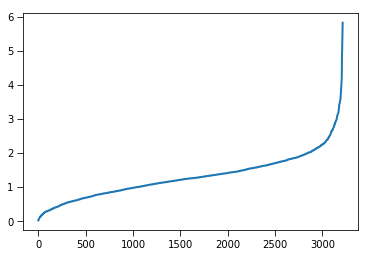

In [118]:
plt.plot(60.*drange[drange.argsort()])

In [85]:
print(G['indx'].astype('int').size)
print(np.unique(G['indx'].astype('int')).size)

g = np.where( (G['astrometric_params_solved']==31) &\
              (G['astrometric_matched_observations']>=8) &\
              (G['dist']<0.0001) &\
              ((G['parallax']+0.029)/G['parallax_error'] < 5) &\
              (((G['pmra']/G['pmra_error'])**2. + (G['pmdec']/G['pmdec_error'])**2.) < 25))


print(g[0].size)

4266
4258
3214


In [95]:
print(np.nanmean(G['pmra'][g]))
print(np.nanmean(G['pmdec'][g]))

0.01144901336569322
0.033013222868138056


In [140]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h


#https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
print(mean_confidence_interval(G['pmra'][g], confidence=0.95))
print(mean_confidence_interval(G['pmdec'][g], confidence=0.95))
print(mean_confidence_interval(G['pmra'][g], confidence=0.67))
print(mean_confidence_interval(G['pmdec'][g], confidence=0.67))

(0.01144901336569322, 0.04340198414496515)
(0.033013222868138056, 0.037605009257034264)
(0.01144901336569322, 0.02156619129053955)
(0.033013222868138056, 0.018685708478463448)


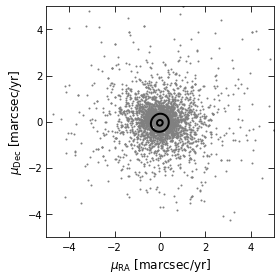

In [148]:

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)


ax.scatter(G['pmra'][g],G['pmdec'][g],color='gray',s=1.)
#ax.contour(xx,yy,qsos,10.**np.linspace(-1.5,0.,8),colors='black')
ax.contour(xx,yy,qsos,[10.**-0.6,10.**-.5],colors='black')



ax.axis([-5.,5.,-5.,5.])

ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(axis="y",which='both',direction="in")
ax.tick_params(axis="x",which='both',direction="in",pad=5)
ax.set_xlabel('$\\mu_{\\rm RA}$ [marcsec/yr]',size=12)
ax.set_ylabel('$\\mu_{\\rm Dec}$ [marcsec/yr]',size=12)

fig.tight_layout()
plt.savefig('figures/propermotionspace_qsos.png',dpi=300)



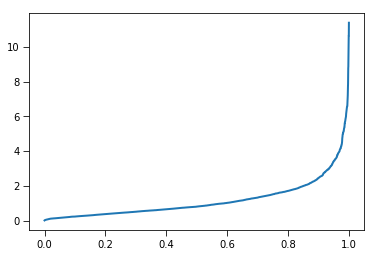

In [101]:
tprop = np.sqrt(G['pmra'][g]*G['pmra'][g]+G['pmdec'][g]*G['pmdec'][g])
plt.plot(np.linspace(0.,1.,tprop.size),tprop[tprop.argsort()])

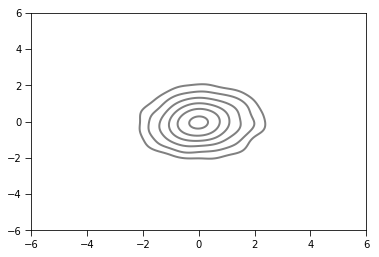

In [136]:
from exptool.utils import kde_3d

xx,yy,qsos = kde_3d.total_kde_two(G['pmra'][g],G['pmdec'][g],\
                                       gridsize=256,\
                                       extents=(-6.,6.,-6.,6.),\
                                       ktype='gaussian',npower=7.)

plt.contour(xx,yy,qsos,10.**np.linspace(-2.0,0.,8),colors='grey')


(-3.0, 0.0)

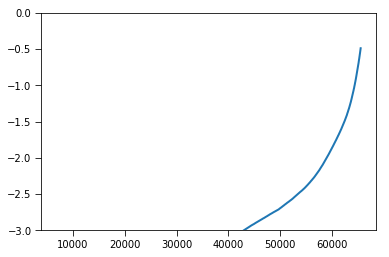

In [138]:
qsosflag = qsos.reshape(-1,)
plt.plot(np.log10(qsosflag[qsosflag.argsort()]))
plt.ylim(-3.,0.)

In [154]:
vl = 220.
rad = 10.
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
dmul=vl / dk * par
print(dmul)

4.640792141029454


(0.0, 10.0)

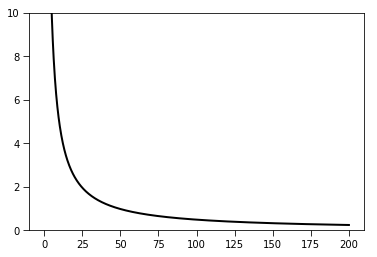

In [97]:
vl = 232.
rad = np.linspace(0.,200.,1000)
dk  =4.74057           #conversion from km/s
par =1./rad             #arc sec --> rad in [kpc]
dmul=vl / dk * par

# from the galactic centre
plt.plot(rad,dmul,color='black')

plt.ylim(0.,10.)